# Data Import

In [1]:
import pandas as pd

# fMRI data
TRAIN_FMRI_PATH = "data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_fmri_df = pd.read_csv(TRAIN_FMRI_PATH)

# Quantitative metadata
TRAIN_QUANT_PATH = "data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"
train_quant_df = pd.read_excel(TRAIN_QUANT_PATH)

# Solutions
TRAIN_SOLUTIONS_PATH = "data/TRAIN/TRAINING_SOLUTIONS.xlsx"
train_solutions_df = pd.read_excel(TRAIN_SOLUTIONS_PATH)

# Principal Component Analysis

Reduced to 1188 principal components


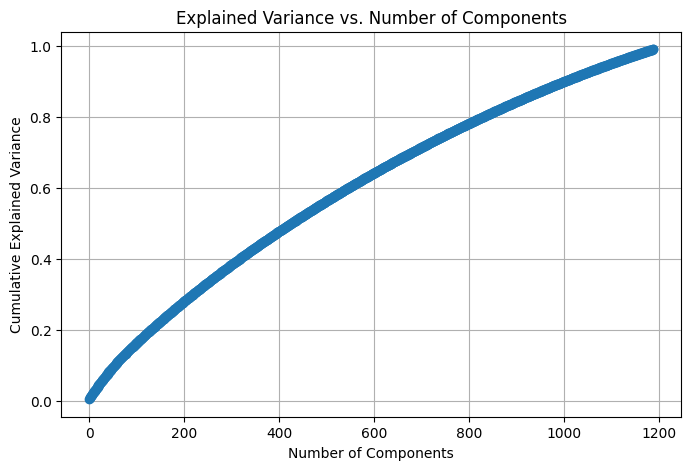

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract activation data (excluding participant ID)
X = train_fmri_df.iloc[:, 1:].values  # Shape (n_samples, 19900)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.99)  # Retain 99% of variance
X_pca = pca.fit_transform(X)  # Shape: (n_samples, reduced_dim)

# Print number of components selected
print(f"Reduced to {X_pca.shape[1]} principal components")

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

In [3]:
# Based on: https://stackoverflow.com/a/56722874/11620221
# Number of components
num_components = pca.components_.shape[0]

# Get the index of the most important feature 
# on EACH component i.e. largest absolute value
most_important = [np.abs(pca.components_[i]).argmax() for i in range(num_components)]

initial_feature_names = train_fmri_df.columns[1:]

# get the names
most_important_col_names = [initial_feature_names[most_important[i]] for i in range(num_components)]
most_important_col_names[:5]

['26throw_129thcolumn',
 '52throw_53thcolumn',
 '37throw_60thcolumn',
 '30throw_56thcolumn',
 '159throw_177thcolumn']

In [4]:
QUANT_INDICES = [0, 9, *range(11, 18)] # Skip Difficulties_Total
train_merged_df = pd.merge(
    # Select only the most important features
    train_fmri_df.loc[:, ["participant_id", *most_important_col_names]],
    train_quant_df.iloc[:, QUANT_INDICES],
    on="participant_id",
)

train_merged_df = pd.merge(train_merged_df, train_solutions_df, on="participant_id")

# Model Selection

In [5]:
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

# Custom loss function to account for class imbalance
def weighted_binary_crossentropy(y_true, y_pred, weight_0, weight_1):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

    loss = -(
        weight_0 * (1 - y_true) * K.log(1 - y_pred) + weight_1 * y_true * K.log(y_pred)
    )

    return K.mean(loss)


# Compute class weights
adhd_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_solutions_df.iloc[:, 1])
sex_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_solutions_df.iloc[:, 2])

adhd_loss = lambda y_true, y_pred: weighted_binary_crossentropy(
    y_true, y_pred, weight_0=adhd_weights[0], weight_1=adhd_weights[1]
)
sex_loss = lambda y_true, y_pred: weighted_binary_crossentropy(
    y_true, y_pred, weight_0=sex_weights[0], weight_1=sex_weights[1]
)

In [6]:
from tensorflow.keras import layers, Input, optimizers, metrics
from tensorflow.keras.models import Model


def create_hypermodel(hp):
    # MRI Input Branch (num_components features)
    mri_input = Input(shape=(num_components,), name="mri_input")
    x1 = mri_input

    # Add multiple dense layers with hyperparameter tuning
    for i in range(hp.Int("num_mri_layers", 1, 3)):
        x1 = layers.Dense(
            units=hp.Int(
                f"mri_units_{i}",
                min_value=16,
                max_value=int(num_components / 2),
                step=32,
            ),
            activation="relu",
        )(x1)

    # Questionnaire Input Branch
    # -1 to exclude participant ID
    survey_input = Input(shape=(len(QUANT_INDICES) - 1,), name="survey_input")
    x2 = layers.Dense(len(QUANT_INDICES) * 3, activation="relu")(survey_input)

    # Merge both feature representations
    merged = layers.Concatenate()([x1, x2])

    # Add multiple dense layers with hyperparameter tuning
    for i in range(hp.Int("num_layers", 1, 3)):
        merged = layers.Dense(
            units=hp.Int(
                f"units_{i}", min_value=16, max_value=num_components / 3, step=32
            ),
            activation="relu",
        )(merged)

    # Add a final Dense layer with two units and
    # sigmoid activation for binary classification
    # (1 = ADHD, 0 = No ADHD / 1 = Female, 0 = Male)
    output_adhd = layers.Dense(1, activation="sigmoid", name="adhd_output")(merged)
    output_sex = layers.Dense(1, activation="sigmoid", name="sex_output")(merged)

    # Compile the model with:
    # - weighted binary cross-entropy loss
    # - Adam optimizer
    # - AUC metric
    model = Model(inputs=[mri_input, survey_input], outputs=[output_adhd, output_sex])
    model.compile(
        loss={
            "adhd_output": adhd_loss,
            "sex_output": sex_loss,
        },
        metrics={
            "adhd_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
            ],
            "sex_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
            ],
        },
        optimizer=optimizers.legacy.Adam(learning_rate=0.001),
    )

    return model

# Model Training & Evaluation

In [7]:
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import KFold

MAX_EPOCHS = 50


def model_eval(X_mri, X_SDQ, targets):
    # Initialize the RandomSearch tuner
    # for hyperparameter search based on Area Under Curve
    tuner = kt.RandomSearch(
        create_hypermodel,
        objective=[
            kt.Objective("val_adhd_output_pr_auc", direction="max"),
            kt.Objective("val_sex_output_pr_auc", direction="max"),
        ],
        directory="archive",
        project_name="bayes",
        overwrite=True,
    )

    # K-fold Cross Validation fold counter
    fold_no = 1

    # Define per-fold score containers
    loss_per_fold = []
    auc_per_fold = []

    # Initialize K-fold cross-validation with 3 splits
    kfolder = KFold(n_splits=3, shuffle=True, random_state=42)

    # Go through each fold
    for train, val in kfolder.split(X_mri, targets):
        # Get the training data
        input_vectors = [X_mri[train], X_SDQ[train]]
        y_train = targets[train]
        y_train_vectors = [y_train[:, 0], y_train[:, 1]]

        # Perform hyperparameter search with Keras Tuner
        tuner.search(
            input_vectors,
            y_train_vectors,
            validation_split=0.2,
            verbose=False,
        )

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters()[0]

        # Build the model with the optimal hyperparameters and train it
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(
            input_vectors,
            y_train_vectors,
            epochs=MAX_EPOCHS,
            validation_split=0.2,
            verbose=False,
        )

        # Find the best epoch based on validation auc
        val_auc_adhd_per_epoch = history.history["val_adhd_output_pr_auc"]
        val_auc_sex_per_epoch = history.history["val_sex_output_pr_auc"]
        best_epoch = int(
            (
                val_auc_adhd_per_epoch.index(max(val_auc_adhd_per_epoch))
                + val_auc_sex_per_epoch.index(max(val_auc_sex_per_epoch))
                + 2
            )
            / 2
        )

        # Retrain the model on the best hyperparameters and epoch
        hypermodel = tuner.hypermodel.build(best_hps)
        hypermodel.fit(
            input_vectors,
            y_train_vectors,
            epochs=best_epoch,
            validation_split=0.2,
            verbose=False,
        )

        # Vectorize the validation data
        input_vectors_val = [X_mri[val], X_SDQ[val]]
        y_val = targets[val]
        y_val_vectors = [y_val[:, 0], y_val[:, 1]]

        # Evaluate the model on the validation data
        (
            loss,
            adhd_output_loss,
            sex_output_loss,
            adhd_output_roc_auc,
            adhd_output_pr_auc,
            sex_output_roc_auc,
            sex_output_pr_auc,
        ) = hypermodel.evaluate(input_vectors_val, y_val_vectors, verbose=False)

        loss_per_fold.append(loss)
        auc_per_fold.append((adhd_output_pr_auc + sex_output_pr_auc) / 2)

        # Increase fold number
        fold_no = fold_no + 1

    # Return the best hyperparameters and their
    # corresponding F1 and loss metrics
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    hp_data = {
        "loss": round(np.mean(loss_per_fold), 3),
        "auc": round(np.mean(auc_per_fold), 3),
        "num_mri_layers": best_hps.values["num_mri_layers"],
        "num_layers": best_hps.values["num_layers"],
    }

    # Capture the best model's structure
    # Track the sequence of layer(s)
    # and their no. of units
    mri_units = []
    units = []

    # Iterate over num_mri_layers
    for i in range(best_hps.values["num_mri_layers"]):
        try:
            # Track no. of mri layers and units
            if best_hps.values[f"mri_units_{i}"]:
                num_mri_units = best_hps.values[f"mri_units_{i}"]

                # Save the number of units per
                # layer in the correct sequence
                mri_units.append(str(num_mri_units))

        except:
            pass

    # Iterate over num_layers
    for i in range(best_hps.values["num_layers"]):
        try:
            # Track the no. of layers and units
            # after the merge
            if best_hps.values[f"units_{i}"]:
                num_units = best_hps.values[f"units_{i}"]

                # Save the number of units per
                # layer in the correct sequence
                units.append(str(num_units))

        except:
            pass

    # Store in hp_data for return
    hp_data["mri_units"] = mri_units
    hp_data["units"] = units

    return hp_data

Using TensorFlow backend


In [8]:
def find_best_model(tries, X_mri, X_SDQ, y_train):
    # Track metric & hyperparameter
    # information about the neural networks
    data = []

    for _ in range(tries):
        # Find and save the best neural network structure
        data.append(model_eval(X_mri, X_SDQ, y_train))

    # Print a table summarizing the neural networks' structures
    print("Loss\t", "AUC\t", "Hidden MRI Layers\t", "Hidden Layers\t")

    max_auc_index = -1
    max_auc = 0

    for i in range(len(data)):
        hp_data = data[i]

        print(
            f"{hp_data['loss']}\t",
            f"{hp_data['auc']}\t",
            f"{' → '.join(hp_data['mri_units'])}\t",
            f"{' → '.join(hp_data['units'])}\t",
        )

        if (hp_data["auc"] > max_auc):
            max_auc = hp_data["auc"]
            max_auc_index = i

    return data[max_auc_index]

In [9]:
from sklearn.preprocessing import StandardScaler

# Try to find the best neural network structure, 10 times
X = train_merged_df.iloc[:, 1:-2]  # 26throw_129thcolumn ... whatever column
y = train_merged_df.iloc[:, -2:].values.astype("float32")  # [ADHD_Outcome, Sex_F]

# Correctly slice the input arrays
X_mri = X.iloc[:, :num_components].values
X_SDQ_unscaled = X.iloc[:, num_components:].values

scaler = StandardScaler()
X_SDQ_scaled = scaler.fit_transform(X_SDQ_unscaled)

best_model_data = find_best_model(10, X_mri.copy(), X_SDQ_scaled.copy(), y.copy())

Loss	 AUC	 Hidden MRI Layers	 Hidden Layers	
1.199	 0.683	 208 → 80	 304 → 272 → 112	
1.189	 0.672	 432 → 16	 368 → 112 → 16	
1.231	 0.668	 368 → 368	 368 → 16	
1.237	 0.684	 560	 272	
1.21	 0.66	 240	 240 → 80 → 208	
1.239	 0.654	 304	 48 → 176 → 208	
1.474	 0.644	 464 → 528 → 432	 176 → 16 → 16	
1.187	 0.687	 208 → 272	 368 → 240	
1.201	 0.685	 240 → 432 → 80	 304 → 80	
1.288	 0.65	 240 → 80	 144 → 176 → 16	


# Predicting Labels and Performance Evaluation

In [10]:
from sklearn.model_selection import train_test_split


def create_model(num_mri_layers, num_layers):
    # MRI Input Branch (num_components features)
    mri_input = Input(shape=(num_components,), name="mri_input")
    x1 = mri_input

    # Add multiple dense layers with hyperparameter tuning
    for i in range(len(num_mri_layers)):
        x1 = layers.Dense(
            units=int(num_mri_layers[i]),
            activation="relu",
        )(x1)

    # Questionnaire Input Branch
    # -1 to exclude participant ID
    survey_input = Input(shape=(len(QUANT_INDICES) - 1,), name="survey_input")
    x2 = layers.Dense(len(QUANT_INDICES) * 3, activation="relu")(survey_input)

    # Merge both feature representations
    merged = layers.Concatenate()([x1, x2])

    # Add multiple dense layers with hyperparameter tuning
    for i in range(len(num_layers)):
        merged = layers.Dense(
            units=int(num_layers[i]),
            activation="relu",
        )(merged)

    # Add a final Dense layer with two units and
    # sigmoid activation for binary classification
    # (1 = ADHD, 0 = No ADHD / 1 = Female, 0 = Male)
    output_adhd = layers.Dense(1, activation="sigmoid", name="adhd_output")(merged)
    output_sex = layers.Dense(1, activation="sigmoid", name="sex_output")(merged)

    # Compile the model with:
    # - weighted binary cross-entropy loss
    # - Adam optimizer
    # - AUC metric
    model = Model(inputs=[mri_input, survey_input], outputs=[output_adhd, output_sex])
    model.compile(
        loss={
            "adhd_output": adhd_loss,
            "sex_output": sex_loss,
        },
        metrics={
            "adhd_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
            ],
            "sex_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
            ],
        },
        optimizer=optimizers.legacy.Adam(learning_rate=0.001),
    )

    return model


# Re-create the model from the best hyperparameters
best_model = create_model(best_model_data["mri_units"], best_model_data["units"])

# Train-test split on our training dataset (1213 rows)
X_mri_train, X_mri_test, X_SDQ_train, X_SDQ_test, y_train, y_test = train_test_split(
    X_mri, X_SDQ_scaled, y, test_size=0.2, random_state=42
)

# Train the model
best_model.fit(
    [X_mri_train, X_SDQ_train],
    [y_train[:, 0], y_train[:, 1]],
    verbose=False,
)

# Predict classes
y_pred = best_model.predict([X_mri_test, X_SDQ_test])
y_pred

8/8 [==============================] - 0s 1ms/step


[array([[0.90963614],
        [0.7903196 ],
        [0.7839712 ],
        [0.5924528 ],
        [0.683014  ],
        [0.09244531],
        [0.19396928],
        [0.45271596],
        [0.47896862],
        [0.05666504],
        [0.8115389 ],
        [0.6120282 ],
        [0.7375614 ],
        [0.81564975],
        [0.7073537 ],
        [0.80269176],
        [0.7179995 ],
        [0.20746933],
        [0.83103794],
        [0.256829  ],
        [0.809803  ],
        [0.7841787 ],
        [0.14425391],
        [0.8056663 ],
        [0.0953713 ],
        [0.46487397],
        [0.09197579],
        [0.656679  ],
        [0.1293897 ],
        [0.11330918],
        [0.7785657 ],
        [0.82813346],
        [0.65859306],
        [0.772152  ],
        [0.8255535 ],
        [0.42888403],
        [0.54050237],
        [0.27118888],
        [0.761487  ],
        [0.63477457],
        [0.86751246],
        [0.7177897 ],
        [0.40264252],
        [0.7629126 ],
        [0.69987947],
        [0

In [11]:
best_model.save("nn-sdq-model")

INFO:tensorflow:Assets written to: nn-sdq-model/assets


INFO:tensorflow:Assets written to: nn-sdq-model/assets


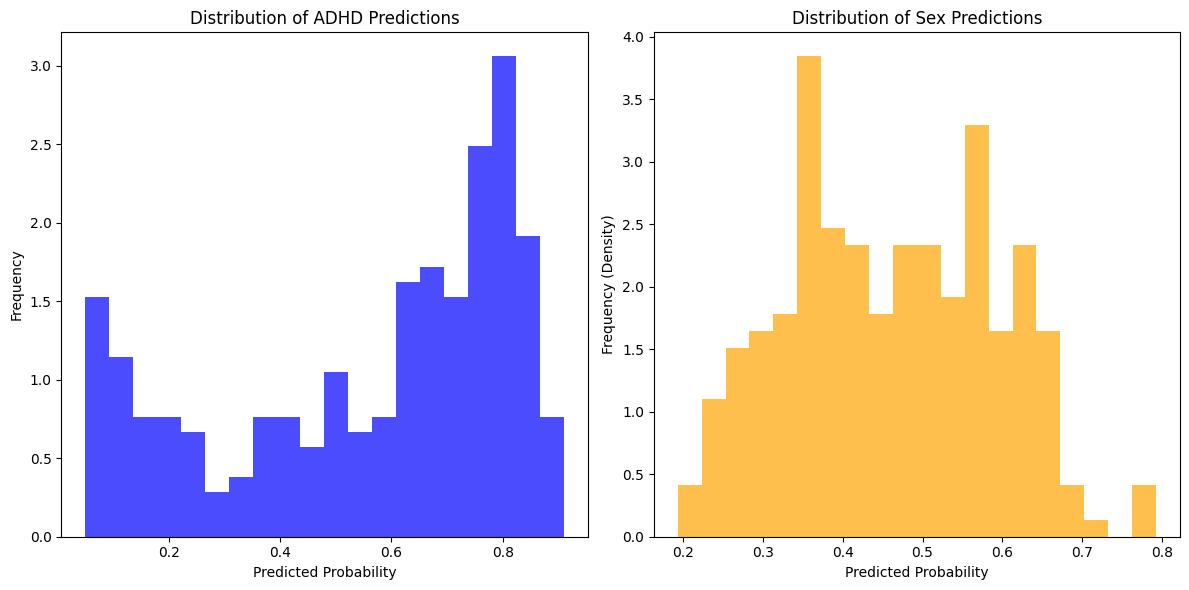

In [12]:
plt.figure(figsize=(12, 6))

# ADHD Prediction Distribution
plt.subplot(1, 2, 1)
plt.hist(y_pred[0], bins=20, color='blue', density=True, alpha=0.7)
plt.title('Distribution of ADHD Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

# Sex Prediction Distribution
plt.subplot(1, 2, 2)
plt.hist(y_pred[1], bins=20, color='orange', density=True, alpha=0.7)
plt.title('Distribution of Sex Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Density)')

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Evaluate the best model on the test set
y_test_vector = [y_test[:, 0], y_test[:, 1]]
converted_y_pred = [
    (np.array(y_pred[0]) >= 0.5).astype(int),
    (np.array(y_pred[1]) >= 0.5).astype(int),
]

# Calculate ROC-AUC score for each output
roc_auc_adhd = roc_auc_score(y_test_vector[0], converted_y_pred[0])
roc_auc_sex = roc_auc_score(y_test_vector[1], converted_y_pred[1])

# Report the ROC-AUC score on the test set
print("ROC-AUC Score on Test Set (ADHD):", roc_auc_adhd)
print("ROC-AUC Score on Test Set (Sex):", roc_auc_sex)

# Calculate accuracy for each output
accuracy_adhd = accuracy_score(y_test_vector[0], converted_y_pred[0])
accuracy_sex = accuracy_score(y_test_vector[1], converted_y_pred[1])

# Report the accuracy on the test set
print("Accuracy Score on Test Set (ADHD):", accuracy_adhd)
print("Accuracy Score on Test Set (Sex):", accuracy_sex)

# Print classification report for each output
print("")
print("Classification Report (ADHD):")
print(classification_report(y_test_vector[0], converted_y_pred[0], zero_division=True))
print("Classification Report (Sex):")
print(classification_report(y_test_vector[1], converted_y_pred[1], zero_division=True))

ROC-AUC Score on Test Set (ADHD): 0.7675438596491229
ROC-AUC Score on Test Set (Sex): 0.6022875816993463
Accuracy Score on Test Set (ADHD): 0.7860082304526749
Accuracy Score on Test Set (Sex): 0.6172839506172839

Classification Report (ADHD):
              precision    recall  f1-score   support

         0.0       0.62      0.72      0.67        72
         1.0       0.87      0.81      0.84       171

    accuracy                           0.79       243
   macro avg       0.75      0.77      0.75       243
weighted avg       0.80      0.79      0.79       243

Classification Report (Sex):
              precision    recall  f1-score   support

         0.0       0.71      0.66      0.68       153
         1.0       0.49      0.54      0.51        90

    accuracy                           0.62       243
   macro avg       0.60      0.60      0.60       243
weighted avg       0.63      0.62      0.62       243



# Kaggle Submission

In [14]:
# Import the test dataset
TEST_FMRI_PATH = "data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_fmri_df = pd.read_csv(TEST_FMRI_PATH)

TEST_QUANT_PATH = "data/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_quant_df = pd.read_excel(TEST_QUANT_PATH)

# Merge the test datasets
test_merged_df = pd.merge(
    test_fmri_df.loc[:, ["participant_id", *most_important_col_names]],
    test_quant_df.iloc[:, QUANT_INDICES],
    on="participant_id",
)

# Correctly slice the input arrays
X_mri_test = test_merged_df.iloc[:, 1 : num_components + 1].values
X_SDQ_unscaled_test = test_merged_df.iloc[:, num_components + 1 :].values

X_SDQ_scaled_test = scaler.transform(X_SDQ_unscaled_test)

# Predict classes
y_pred = best_model.predict([X_mri_test, X_SDQ_scaled_test])

converted_y_pred = [
    (np.array(y_pred[0]) >= 0.5).astype(int),
    (np.array(y_pred[1]) >= 0.5).astype(int),
]

# Save the predictions to a CSV file
output_df = test_merged_df.loc[:, ["participant_id"]]
output_df["ADHD_Outcome"] = converted_y_pred[0].flatten()
output_df["Sex_F"] = converted_y_pred[1].flatten()
output_df.to_csv("predictions.csv", index=False)

10/10 [==============================] - 0s 1ms/step
